In [74]:
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split


RANDOM_SEED=42

np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# Download Dataset

In [75]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, parser='auto')

X = X.values
y = y.astype(int).values

In [76]:
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


# Normalize Pixels Values To [-1, 1] Range

In [77]:
X = ((X / 255.) - .5) * 2

# Data Visualization

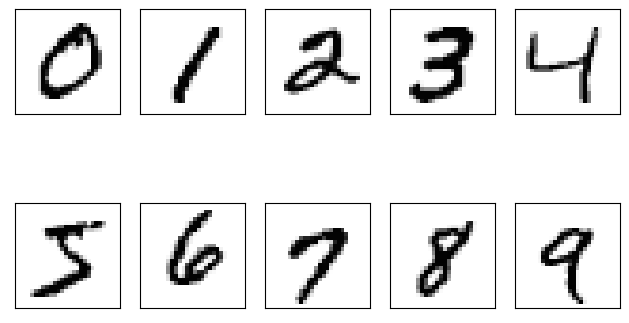

In [78]:
fig, axes = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)

ax = axes.flatten()

for i in range(10):
    img = X[y == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()

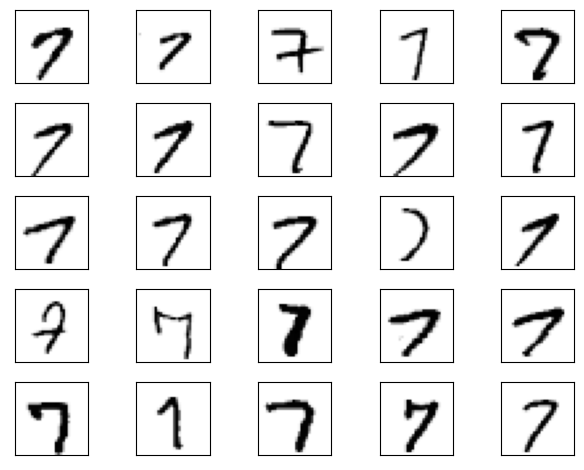

In [79]:
fig, axes = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)

ax = axes.flatten()

for i in range(25):
    img = X[y == 7][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')
    
ax[0].set_xticks([])
ax[0].set_yticks([])
fig.tight_layout()

# Train, Val, Test Split

In [80]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=10_000, random_state=RANDOM_SEED, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=5000, random_state=RANDOM_SEED, stratify=y_temp)

print(f"Train : X: {X_train.shape} y: {y_train.shape}")
print(f"Val : X: {X_val.shape} y: {y_val.shape}")
print(f"Test : X: {X_test.shape} y: {y_test.shape}")

Train : X: (55000, 784) y: (55000,)
Val : X: (5000, 784) y: (5000,)
Test : X: (10000, 784) y: (10000,)


# Multilayer Perceptron Implementation

In [81]:
def sigmoid(z):
    return 1. / (1. + np.exp(-z))


def int_to_onehot(y, num_labels):
    
    onehot_encoded_matrix = np.zeros((y.shape[0], num_labels))
    for sample_index, label in enumerate(y):
        onehot_encoded_matrix[sample_index, label] = 1
    
    return onehot_encoded_matrix

In [82]:
class MultilayerPerceptronNeuralNetwork:
    
    def __init__(self, num_features: int, num_hidden_neurons: int, num_classes: int, random_seed: int):
        super().__init__()
        
        self.num_classes = num_classes
        
        rng = np.random.RandomState(random_seed)
        
        self.weight_h1 = rng.normal(loc=0.0, scale=0.1, size=(num_hidden_neurons, num_features)) # dxm
        self.bias_h1 = np.zeros(num_hidden_neurons) #dx1
        
        self.weight_out = rng.normal(loc=0.0, scale=0.1, size=(num_classes, num_hidden_neurons)) # txd
        self.bias_out = np.zeros(num_classes) #tx1
    
    
    def forward(self, x: np.ndarray) -> tuple:
        """Performs a forward pass in the neural network.

        Args:
            x (np.ndarray): Input of shape nxm where n is the number of rows and m is the number of features.

        Returns:
            tuple: Output is a tuple of 2 values.
                    The first value is the hidden layer activation output which is of shape n x d where n is the number of rows and d is the number of neurons in the hidden layer.
                    The second output is the class-membership probabilities for each classes which is of shape n x t where n is the number of rows and t is the number of classes.
        """
        z_h1 = np.dot(x, self.weight_h1.T) + self.bias_h1 # Result is nxd
        a_h1 = sigmoid(z_h1)
        
        z_out = np.dot(a_h1, self.weight_out.T) + self.bias_out # Result is nxt
        a_out = sigmoid(z_out)
        
        return a_h1, a_out
    
    
    def backward(self, x: np.ndarray, a_h1: np.ndarray, a_out: np.ndarray, y: np.ndarray):
        y_onehot = int_to_onehot(y, self.num_classes)
        
        n = x.shape[0]
        
        # Part 1 : dLoss/dOutWeights
        d_loss__d_a_out = 2.*(a_out - y_onehot) / n # MSE derivative (divided by number of examples : n)
        
        d_a_out__d_z_out = a_out * (1. - a_out) # Sigmoid derivative
        
        # Here we create a variable 'delta_out' for dLoss/dZ_out because it can be re-used for the partial derivative of the hidden layer (saves re-computing the value)
        delta_out = d_loss__d_a_out * d_a_out__d_z_out
        
        # gradient for output weights
        
        d_z_out__dw_out = a_h1
        
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)
        d_loss__db_out = np.sum(delta_out, axis=0)
        
        # Part 2 : dLoss/dHiddenWeights1
        d_z_out__a_h1 = self.weight_out
        
        d_loss__a_h1 = np.dot(delta_out, d_z_out__a_h1)
        
        d_a_h1__d_z_h1 = a_h1 * (1. - a_h1) # Sigmoid derivative
        d_z_h1__d_w_h1 = x
        
        d_loss__dw_h1 = np.dot((d_loss__a_h1 * d_a_h1__d_z_h1).T, d_z_h1__d_w_h1)
        d_loss__db_h1 = np.sum((d_loss__a_h1 * d_a_h1__d_z_h1), axis=0)
        
        return (d_loss__dw_out, d_loss__db_out, d_loss__dw_h1, d_loss__db_h1)

In [83]:
model = MultilayerPerceptronNeuralNetwork(num_features=28*28, num_hidden_neurons=50, num_classes=10, random_seed=RANDOM_SEED)

# Dataloader

In [84]:
def get_data_loader(X: np.ndarray, y: np.ndarray, batch_size: int, shuffle: bool):
    indices = np.arange(start=0, stop=X.shape[0], step=1)
    
    if shuffle:
        np.random.shuffle(indices)
    
    for start_idx in range(0, indices.shape[0] - batch_size + 1, batch_size):
        batch_idx = indices[start_idx:start_idx + batch_size]
        yield X[batch_idx], y[batch_idx]

## Test the dataloader

In [85]:
num_epochs = 1
batch_size = 100

for i in range(num_epochs):
    data_loader = get_data_loader(X_train, y_train, batch_size, shuffle=False)
    
    for X_train_batch, y_train_batch in data_loader:
        print(f"Expected batch size: {batch_size}")
        print(f"X_train_batch: {X_train_batch.shape}")
        print(f"y_train_batch: {y_train_batch.shape}")
        
        assert batch_size == X_train_batch.shape[0]
        assert batch_size == y_train_batch.shape[0]
        break 
    break

Expected batch size: 100
X_train_batch: (100, 784)
y_train_batch: (100,)


# Loss Function & Performance Metric

In [86]:
def compute_mse_loss(targets: np.ndarray, probas: np.ndarray, num_labels: int):
    onehot_targets = int_to_onehot(targets, num_labels)
    
    return np.mean((onehot_targets - probas)**2)


def compute_accuracy(targets, predited_labels):
    return np.mean(predited_labels == targets)


def compute_mse_loss_and_accuracy_incrementally(model: MultilayerPerceptronNeuralNetwork, X: np.ndarray, y: np.ndarray, num_labels: int, batch_size: int):
    mse_loss, correct_pred_count, num_examples = 0., 0, 0
    data_loader = get_data_loader(X, y, batch_size, shuffle=False)
    
    for i, (x_batch, y_batch) in enumerate(data_loader):
        _, probas = model.forward(x_batch)
        predicted_labels = np.argmax(probas, axis=1)
        batch_loss = compute_mse_loss(y_batch, probas, num_labels)
        
        correct_pred_count += (predicted_labels == y_batch).sum()
        num_examples += x_batch.shape[0]
        
        mse_loss += batch_loss

    mse_loss = mse_loss / i
    accuracy = correct_pred_count / num_examples
    
    return mse_loss, accuracy

## Test the loss function & performance metric with initial untrained model

In [87]:
_, probas = model.forward(X_val)
mse_loss = compute_mse_loss(y_val, probas, num_labels=model.num_classes)
print(f"Initial validation MSE: {mse_loss:.1f}")

predicted_labels = np.argmax(probas, axis=1)
accuracy = compute_accuracy(y_val, predicted_labels)
print(f"Initial validation accuracy : {accuracy*100:.1f}%")

Initial validation MSE: 0.3
Initial validation accuracy : 9.7%


In [88]:
mse_loss, accuracy = compute_mse_loss_and_accuracy_incrementally(model, X_val, y_val, model.num_classes, batch_size)
print(f"Initial val MSE: {mse_loss:.1f}")
print(f"Initial validation accuracy : {accuracy*100:.1f}%")

Initial val MSE: 0.3
Initial validation accuracy : 9.7%


# Training Loop

In [89]:
def train(model: MultilayerPerceptronNeuralNetwork, 
          X_train: np.ndarray, 
          y_train: np.ndarray, 
          X_val: np.ndarray, 
          y_val: np.ndarray, 
          num_epochs: int, 
          batch_size: int, 
          lr: float
    ):
    
    epoch_loss = []
    epoch_train_accuracy = []
    epoch_val_accuracy = []
    
    for epoch_index in range(num_epochs):
        
        train_data_loader = get_data_loader(X=X_train, y=y_train, batch_size=batch_size, shuffle=True)
        
        for X_train_batch, y_train_batch in train_data_loader:
            a_h1_batch, a_out_batch = model.forward(X_train_batch)
            
            # Compute gradients
            d_loss__dw_out, d_loss__db_out, d_loss__dw_h1, d_loss__db_h1 = model.backward(X_train_batch, a_h1_batch, a_out_batch, y_train_batch)
            
            # Update weights & biases
            model.weight_h1 -= lr * d_loss__dw_h1
            model.bias_h1 -= lr * d_loss__db_h1
            model.weight_out -= lr * d_loss__dw_out
            model.bias_out -= lr * d_loss__db_out

        # Metrics logging #
        train_loss, train_accuracy = compute_mse_loss_and_accuracy_incrementally(model, X_train, y_train, model.num_classes, batch_size)
        _, val_accuracy = compute_mse_loss_and_accuracy_incrementally(model, X_val, y_val, model.num_classes, batch_size)
        
        train_accuracy = train_accuracy * 100
        val_accuracy = val_accuracy * 100
        
        epoch_train_accuracy.append(train_accuracy)
        epoch_val_accuracy.append(val_accuracy)
        epoch_loss.append(train_loss)
        
        print(f"Epoch: {epoch_index+1}/{num_epochs} | Train loss: {train_loss:.4f} | Train acc: {train_accuracy:.2f}% | Val acc: {val_accuracy:.2f}")
    
    return epoch_loss, epoch_train_accuracy, epoch_val_accuracy

# Train Model

In [90]:
epoch_loss, epoch_train_accuracy, epoch_val_accuracy = train(model, 
                                                             X_train, 
                                                             y_train, 
                                                             X_val, 
                                                             y_val, 
                                                             num_epochs=50, 
                                                             batch_size=100,
                                                             lr=0.1
                                                        )

Epoch: 1/50 | Train loss: 0.0534 | Train acc: 72.24% | Val acc: 73.28
Epoch: 2/50 | Train loss: 0.0331 | Train acc: 85.18% | Val acc: 85.66
Epoch: 3/50 | Train loss: 0.0249 | Train acc: 88.26% | Val acc: 89.12
Epoch: 4/50 | Train loss: 0.0211 | Train acc: 89.32% | Val acc: 89.76
Epoch: 5/50 | Train loss: 0.0189 | Train acc: 90.07% | Val acc: 91.10
Epoch: 6/50 | Train loss: 0.0175 | Train acc: 90.60% | Val acc: 91.28
Epoch: 7/50 | Train loss: 0.0165 | Train acc: 90.98% | Val acc: 91.94
Epoch: 8/50 | Train loss: 0.0157 | Train acc: 91.29% | Val acc: 92.06
Epoch: 9/50 | Train loss: 0.0150 | Train acc: 91.58% | Val acc: 92.10
Epoch: 10/50 | Train loss: 0.0145 | Train acc: 91.79% | Val acc: 92.56
Epoch: 11/50 | Train loss: 0.0141 | Train acc: 92.05% | Val acc: 92.78
Epoch: 12/50 | Train loss: 0.0137 | Train acc: 92.20% | Val acc: 92.72
Epoch: 13/50 | Train loss: 0.0134 | Train acc: 92.35% | Val acc: 92.86
Epoch: 14/50 | Train loss: 0.0130 | Train acc: 92.56% | Val acc: 93.20
Epoch: 15/50 | 

# Evaluate Neural Network Performance

Text(0.5, 1.0, 'Training Loss')

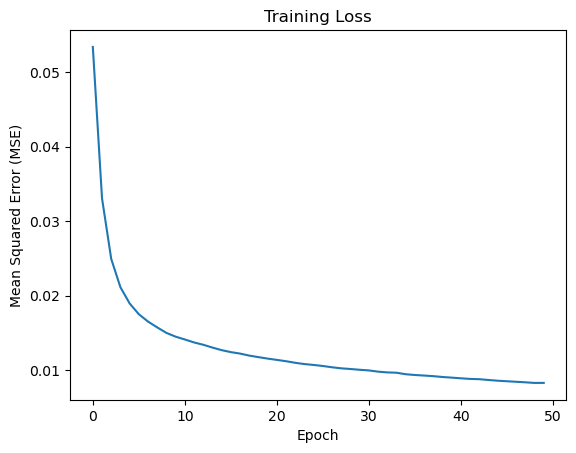

In [91]:
fig, ax = plt.subplots()
ax.plot(range(len(epoch_loss)), epoch_loss)
ax.set_ylabel('Mean Squared Error (MSE)')
ax.set_xlabel('Epoch')
ax.set_title('Training Loss')

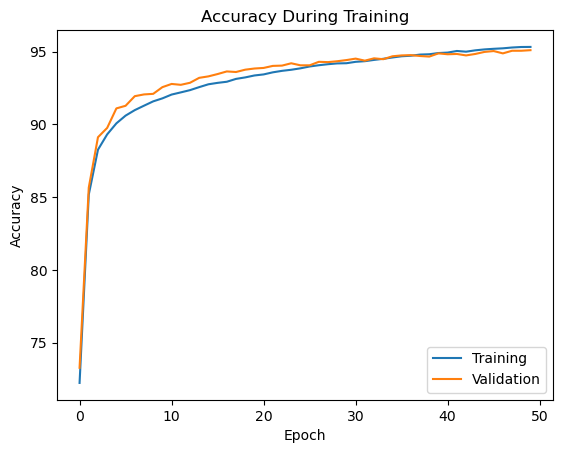

In [92]:
fig, ax = plt.subplots()
ax.plot(range(len(epoch_train_accuracy)), epoch_train_accuracy, label='Training')
ax.plot(range(len(epoch_val_accuracy)), epoch_val_accuracy, label='Validation')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.set_title('Accuracy During Training')
ax.legend(loc='lower right')

In [93]:
test_loss, test_accuracy = compute_mse_loss_and_accuracy_incrementally(model, X_test, y_test, model.num_classes, batch_size=250)

print(f"Test accuracy: {test_accuracy * 100:.2f}%")

Test accuracy: 94.63%


## Analyzing 25 Wrong Results (Test Set)

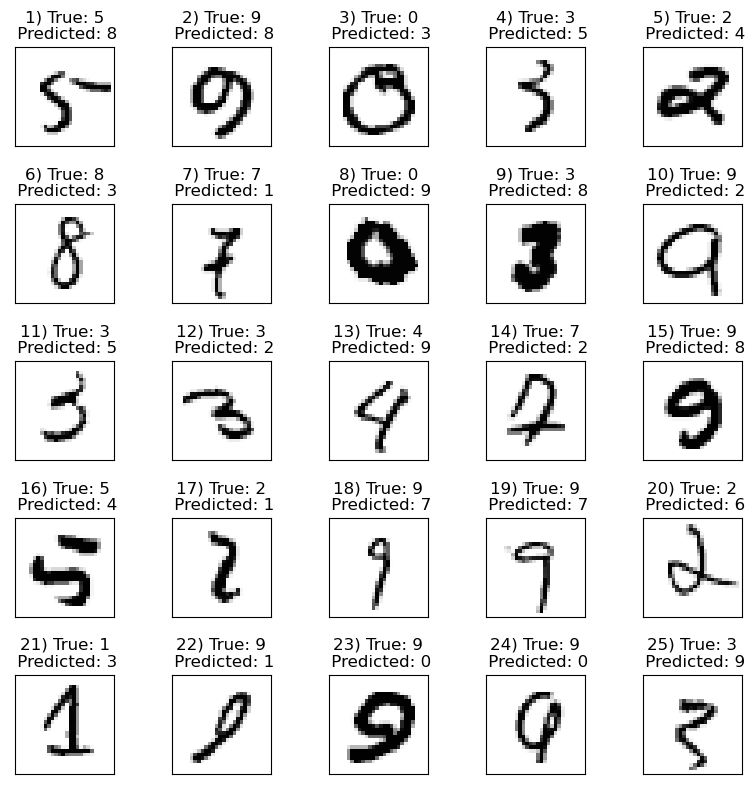

In [94]:
X_test_subset = X_test[:1000, :]
y_test_subset = y_test[:1000]
_, probas = model.forward(X_test_subset)
test_pred = np.argmax(probas, axis=1)

missclasified_images = X_test_subset[y_test_subset != test_pred][:25]
missclasified_labels = test_pred[y_test_subset != test_pred][:25]
correct_labels = y_test_subset[y_test_subset != test_pred][:25]

fig, axes = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True, figsize=(8,8))

ax = axes.flatten()
for i in range(25):
    img = missclasified_images[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title(f"{i+1}) True: {correct_labels[i]}\n Predicted: {missclasified_labels[i]}")
    
ax[0].set_xticks([])
ax[0].set_yticks([])
fig.tight_layout()